In [1]:
from aeon.datasets import load_kdd_tsad_135
X, y = load_kdd_tsad_135()

In [2]:
X.shape, y.shape

((7501,), (7501,))

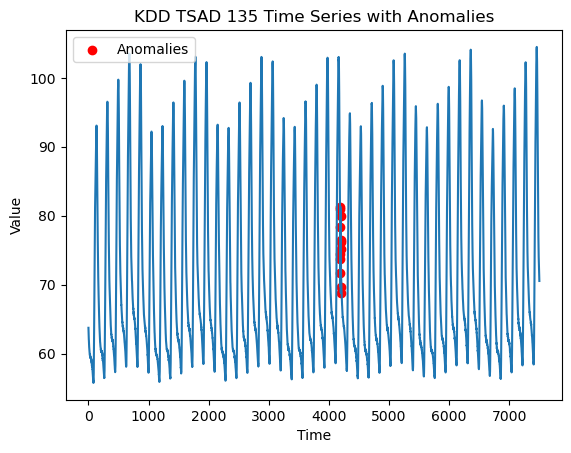

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(X)
plt.scatter(np.where(y == 1), X[y == 1], color='red', label='Anomalies')
plt.title('KDD TSAD 135 Time Series with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
from aeon.datasets import load_ecg_diff_count_3
X_test, y_test, X_train, y_train = load_ecg_diff_count_3("supervised")

In [8]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000,), (10000,), (10000,), (10000,))

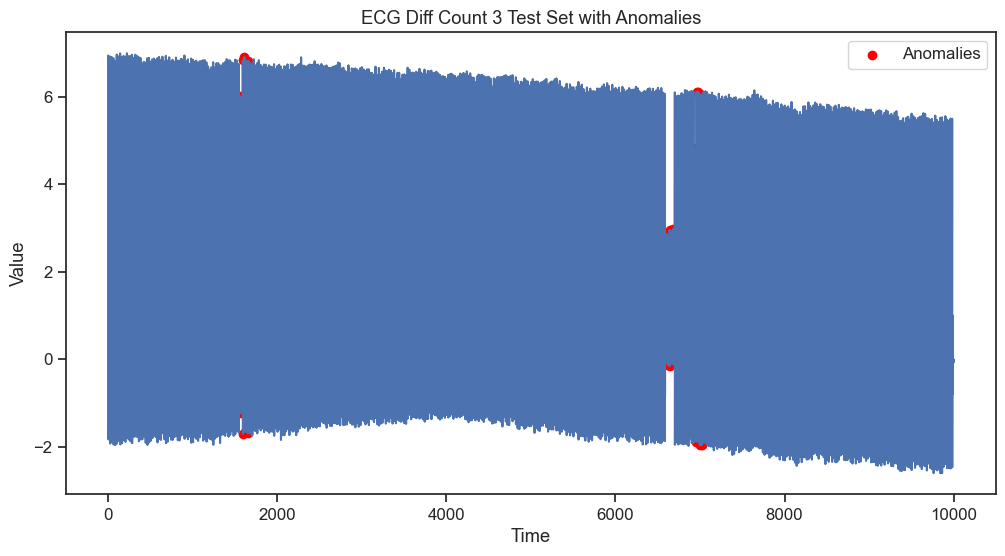

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(X_test)
plt.scatter(np.where(y_test == 1), X_test[y_test == 1], color='red', label='Anomalies')
plt.title('ECG Diff Count 3 Test Set with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()  

🏥 Loading ECG Data (ChinTown dataset)...
Train: (581, 82), Anomaly Count: 291
Test:  (581, 82), Anomaly Count: 290

🧠 Training Cost-Sensitive Ensemble...

🌊 Running Streaming Inference...
📊 Plotting...


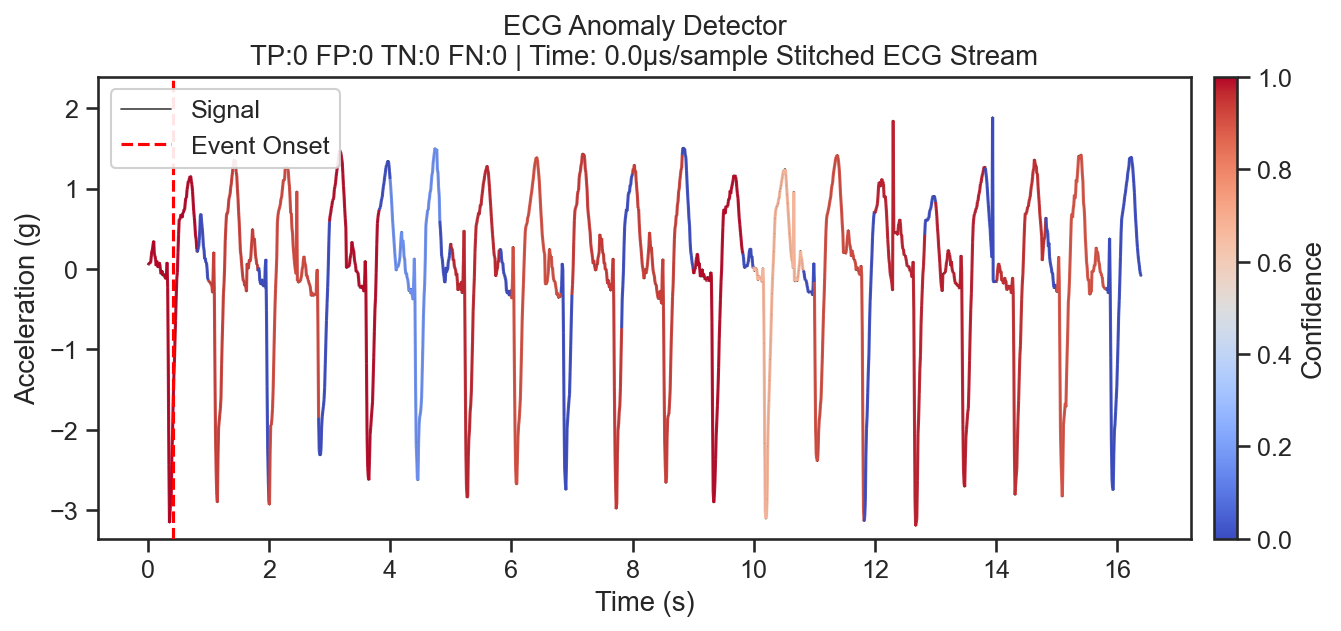

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# You might need to install aeon: pip install aeon
from aeon.datasets import load_classification

# --- Costream Imports ---
from costream.model import CostClassifierCV
from costream.evaluation.tester import run_experiment, ModelSpec
from costream.evaluation.visualization import plot_confidence

def run_ecg_demo():
    print("🏥 Loading ECG Data (ChinTown dataset)...")
    # 'ChinTown' is a simple univariate traffic-like dataset, 
    # but 'ECG200' or 'TwoLeadECG' is better for this context.
    # Let's use 'TwoLeadECG' (Classes: 1=Normal, 2=Abnormal)
    X_data, y_data = load_classification("TwoLeadECG")

    # 1. Adapt Data to Costream Format
    # Aeon gives (N, 1, Length). We need (N, Length) for 1D signals.
    X_data = X_data.squeeze() 
    
    # Convert labels: usually 1 vs 2. We need 0 (Normal) vs 1 (Event/Anomaly)
    # In TwoLeadECG: 1 is Normal, 2 is Abnormal.
    y_data = (y_data.astype(int) == 2).astype(int)

    # Split (Standard Stratified Split)
    from sklearn.model_selection import train_test_split
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.5, stratify=y_data, random_state=42
    )

    print(f"Train: {X_train_raw.shape}, Anomaly Count: {sum(y_train)}")
    print(f"Test:  {X_test_raw.shape}, Anomaly Count: {sum(y_test)}")

    # 2. Train Cost-Sensitive Model
    # "Missing a heart anomaly is 5x worse than a false alarm"
    clf = CostClassifierCV(
        base_estimators=[
            LogisticRegression(max_iter=1000), 
            RandomForestClassifier(n_estimators=50)
        ],
        alpha=5.0, 
        method="stacking"
    )

    print("\n🧠 Training Cost-Sensitive Ensemble...")
    # Note: X_train_raw is already segmented in this dataset.
    # In a full streaming demo, we would stitch them, but here we 
    # demonstrate the Model component directly on time-series windows.
    clf.fit(X_train_raw, y_train)

    # 3. Simulate a "Stream" from Test Data
    # We will stitch 10 test samples together to create a continuous stream
    # containing both normal beats and anomalies.
    stream_signal = np.concatenate(X_test_raw[:20])
    
    # We need to calculate where the events are in this new stream
    # Each sample has length 82 (for TwoLeadECG)
    seg_len = X_test_raw.shape[1]
    stream_events = []
    for i in range(20):
        if y_test[i] == 1:
            # Mark the center of the anomaly window
            stream_events.append(i * seg_len + (seg_len // 2))

    # If no events in the first 20, force one for the demo
    if not stream_events: 
        stream_events = [-1]

    print("\n🌊 Running Streaming Inference...")
    from costream.segmentation.streaming_segmenter import sliding_window_inference
    
    # Run inference on the stitched stream
    conf_map, _ = sliding_window_inference(
        stream_signal, clf, 
        window_size=seg_len/100.0, # Dummy Hz assumption
        step=1.0, 
        freq=100
    )

    # 4. Visualize
    print("📊 Plotting...")
    # Just take the first valid event or -1
    target_event = stream_events[0] if stream_events else -1
    
    plot_confidence(
        ts=stream_signal,
        c=conf_map,
        y=target_event,
        tp=0, fp=0, tn=0, fn=0, # Dummy stats for viz
        model_name="ECG Anomaly Detector",
        title="Stitched ECG Stream"
    )

if __name__ == "__main__":
    run_ecg_demo()